<h1 style="text-align: center; font-family: 'Arial', sans-serif; color: #2c3e50;">
  <strong>Jaca 2025 Summer School: Introduction to Neural Networks Programming and Applied Artificial Intelligence</strong>
</h1>

<h2> July 1-4, 2025 </h2>


---



> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Course coordinator </strong><br>
  David Gonzalez (gonzal@unizar.es)
</p>

> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Authors </strong><br>
  </p>
  Carlos Bermejo-Barbanoj
  </p>
  Alicia Tierz
  </p>
  Mikel M. Iparraguirre
  </p>
  Lucas Tesán
  </p>
  </p>
  Pau Urdeitx


---




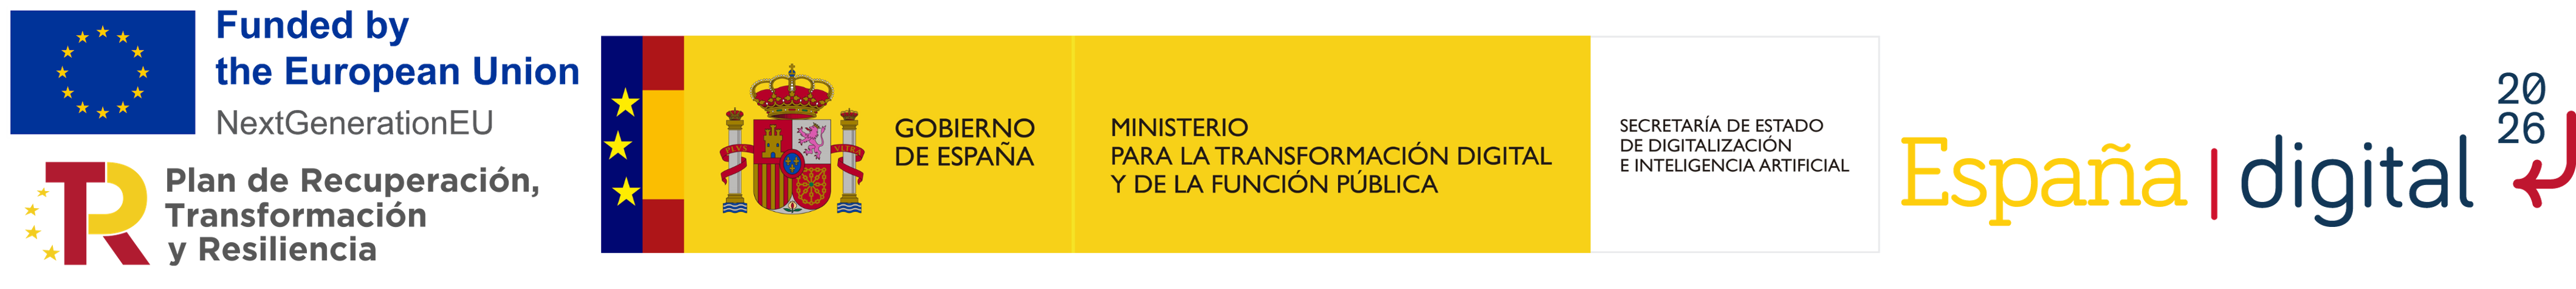

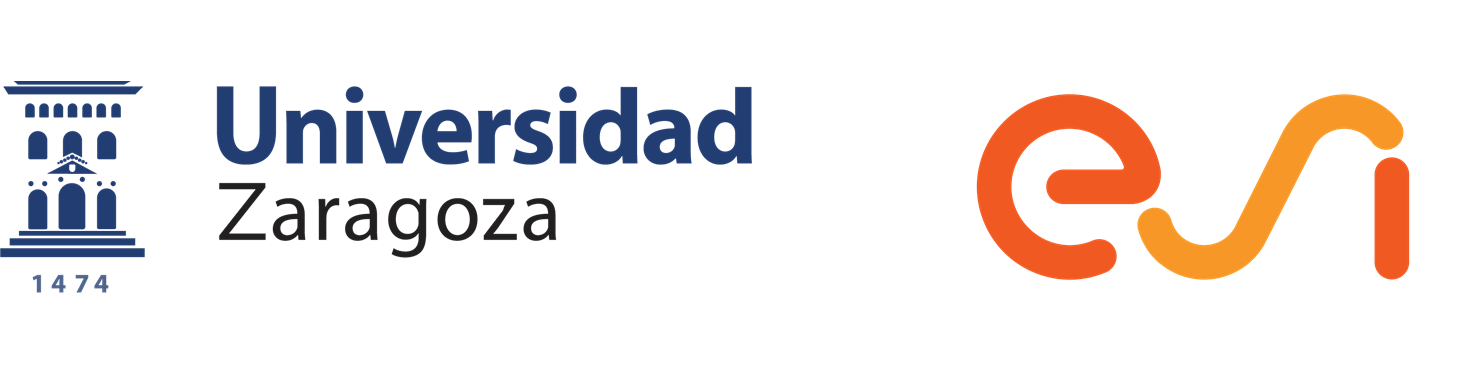

# Chapter 6 Model Optimization: Advanced Training Techniques
---


> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Lecture</strong><br>
  Mikel M. Iparraguirre
</p>

> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Notebook Authors</strong><br>
  </p>
  Mikel M. Iparraguirre
    </p>
  Pau Urdeitx
</p>


---
This notebook assumes familiarity with Python and basic programming concepts. Prior knowledge of neural networks is helpful but not required.

##1. Introduction


When tuning hyperparameters, visual monitoring is essential for understanding how model performance responds to different configurations. **Weights & Biases** (wandb) provides an integrated suite of visual tools that allow researchers and engineers to track, compare, and analyze their experiments efficiently. Below are the most essential plots for hyperparameter optimization:

### Objectives

By the end of this session, participants will be able to:

1. Understand the role of hyperparameter tuning in machine learning workflows and its impact on model performance [1].
2. Use Weights & Biases (wandb) to track, log, and visualize key training metrics in real time.
3. Analyze training dynamics using loss curves, accuracy plots, and run comparisons.
4. Interpret parallel coordinate plots and scatter plots to assess the influence of hyperparameters.
5. Evaluate the importance of different hyperparameters using wandb’s automated tools.
6. Design and manage effective hyperparameter sweeps for model optimization.


To support these objectives, we will explore the most relevant visual tools that wandb offers for analyzing and guiding hyperparameter tuning. These plots help identify optimal configurations, diagnose training issues, and understand the sensitivity of model performance to specific parameters.

Below is a summary of the core visualizations that will be covered and interpreted during this session:

1. **Training vs. Validation Loss Curve**  
   **Purpose**: Identify overfitting or underfitting.  
   **What to look for**: Divergence between loss curves, plateaus, convergence points.  
   **Relevant for**: `learning_rate`, `batch_size`, regularization (`dropout`, `weight_decay`).

2. **Accuracy (or other performance metric) over Epochs**  
   **Purpose**: Evaluate overall performance and stability.  
   **What to look for**: Run-to-run variability, marginal improvements, generalization stability.  
   **Relevant for**: `optimizer`, `activation`, model architecture.

3. **Parallel Coordinates Plot**  
   **Purpose**: Visualize multiple hyperparameters and their effect on a chosen metric.  
   **What to look for**: High-performance paths, parameter sensitivity.  
   **Relevant for**: Global comparison across configurations.

4. **Hyperparameter Importance**  
   **Purpose**: Estimate which hyperparameters have the most influence on performance.  
   **What to look for**: Parameters that contribute most to output variability.  
   **Relevant for**: Prioritizing which parameters to explore further in future sweeps.

5. **Scatter Plot: Metric vs. Hyperparameter**  
   **Purpose**: Analyze direct relationship between a single hyperparameter and a target metric (e.g., accuracy vs. learning rate).  
   **What to look for**: Threshold effects, inflection points, flat or unstable regions.  
   **Relevant for**: `learning_rate`, number of layers/neurons.

6. **Histograms of Metrics**  
   **Purpose**: View distribution of performance across different runs.  
   **What to look for**: Spread, outliers, consistency across seeds.  
   **Relevant for**: Model robustness, variance in performance.

7. **Lineplot with Multiple Runs (Overlay)**  
   **Purpose**: Directly compare training behaviors across configurations.  
   **What to look for**: Divergent behavior, convergence speed, stability.  
   **Relevant for**: Initialization sensitivity, schedulers, batch normalization, etc.

8. **Sweep Summary Table**  
   **Purpose**: Tabular view of key metrics across all sweep configurations.  
   **What to look for**: Final metric values, number of parameters, early stopping triggers.  
   **Relevant for**: Filtering top configurations and further statistical analysis.


Let's start by first loading the necessary packages, **installing wandb**, and defining the dataset we will use throughout this session.

In [1]:
!pip install -q pytorch-lightning

In [4]:
!pip install git+https://github.com/mikelunizar/T6-AdvancedOptimization.git

  Cloning https://github.com/mikelunizar/T6-AdvancedOptimization.git to /tmp/pip-req-build-gja251yt
  Running command git clone --filter=blob:none --quiet https://github.com/mikelunizar/T6-AdvancedOptimization.git /tmp/pip-req-build-gja251yt
  Resolved https://github.com/mikelunizar/T6-AdvancedOptimization.git to commit 84f06ca7bcf1544636c8d281bc8e8ebc2af80e85
  Preparing metadata (setup.py) ... done
  Created wheel for mnist_cnn_lightning: filename=mnist_cnn_lightning-0.1.0-py3-none-any.whl size=1333 sha256=f0b2c20c5e4cfcb9fd14d186206e891dbbd168261dd8b63e26f36dffdfe3511f
  Stored in directory: /tmp/pip-ephem-wheel-cache-kseqhakt/wheels/dd/b4/4f/4806b7e488b90639c55797a5c590736c1c7badfb99ad2c15de
Successfully built mnist_cnn_lightning


In [12]:
from mnist_cnn_lightning import MNISTCNN
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms

ModuleNotFoundError: No module named 'mnist_cnn_lightning'

In [2]:


# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Split train into valid and train sets
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [val_size, train_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=4
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=1,
    dirpath='checkpoints/',
    filename='mnist-cnn-{epoch:02d}-{val_acc:.2f}'
)

early_stopping = EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='max'
)

# Logger
logger = TensorBoardLogger('lightning_logs', name='mnist_cnn')

# Initialize model
model = MNISTCNN(learning_rate=1e-3)

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    accelerator='auto',
    devices='auto'
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Test the model
trainer.test(model, dataloaders=test_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv2d           | 320    | train
1  | bn1  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9950000047683716     │
│         test_loss         │   0.019049473106861115    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.019049473106861115, 'test_acc': 0.9950000047683716}]

In [ ]:
# Install PyTorch Lightning if not already available
!pip install -q pytorch-lightning

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed, workers=True)

set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 61.6 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cpu


Load MNIST Dataset

In [ ]:
# Mean and Standard Deviation
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download data
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_norm)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

# Define batch_size and DataLoaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 21.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 614kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.39MB/s]

Training batches: 938
Test batches: 157


Visualize random samples of the Dataset

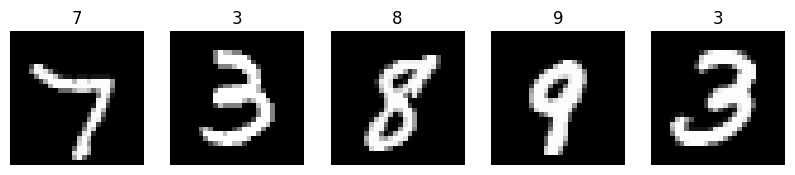

In [ ]:
def plot_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_unnormalized = image * 0.3081 + 0.1307
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image_unnormalized.squeeze(), cmap='gray')
        plt.title(f"{label}")
        plt.axis("off")
    plt.show()

# Plot samples
plot_samples(mnist_train)

Define MPL (same as defined in sesion 3)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        return self.model(x)

Define training and evaluate model functions

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, acc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

##2. Weight and Biases

## 2. Weights & Biases (wandb)

[Weights & Biases](https://www.wandb.ai) is a platform designed to facilitate the tracking, visualization, and management of machine learning experiments [2]. It provides a lightweight API that can be integrated into any training loop to automatically log metrics, model parameters, gradients, losses, and even system performance (e.g., GPU usage).

In this session, we use `wandb` primarily to:

- **Log key metrics** such as training/validation loss and accuracy.
- **Compare different hyperparameter configurations** through visual dashboards.
- **Organize experiment results** using runs, projects, and sweeps.
- **Automate hyperparameter tuning** via configurable sweep agents.

By centralizing the monitoring process, wandb improves the reproducibility, scalability, and interpretability of deep learning experiments. Its web interface allows for intuitive exploration of results, including advanced visualizations such as parallel coordinate plots, metric-vs-parameter scatter plots, and hyperparameter importance analysis.



### Import Weight and Biases

### 2.1 Import Weights & Biases

Using Weights & Biases in your project is straightforward. You only need to:

1. **Install the wandb package** (if not already available).
2. **Import it into your Python environment**.
3. **Log in** to your wandb account using your API key (only once per environment).

Once initialized, all training logs and metadata will be uploaded in real time to your personal or team workspace on the wandb web platform. This enables cloud-based storage, visualization, and comparison of experiments without changing your model code structure.

To use wandb, you need to create a free account at the web page. Alternatively, you can run in **anonymous mode** for quick testing purposes by setting the login mode to `anonymous="must"`.


Here's how to get started:

```python
# Step 1: Install (if necessary)
!pip install wandb

# Step 2: Import
import wandb

# Step 3: Login (you'll be prompted to enter your API key)
wandb.login()
# Alternative: Use anonymous mode (limited functionality)
# wandb.login(anonymous="must")
```

After logging in, every run you initialize with `wandb.init()` will automatically sync data — including metrics, model checkpoints, and configuration — to the wandb app.

> Note: You can access your runs and dashboards at: [https://wandb.ai](https://wandb.ai)


-> Initialize WandB: User + Key

How to get Apu key?
1. Go to: https://wandb.ai/authorize
2. Login with your user
3. Copy the key:

    aB3x9FgH7kLmN2pQrS8tUv4wZ5yZ1j0O

    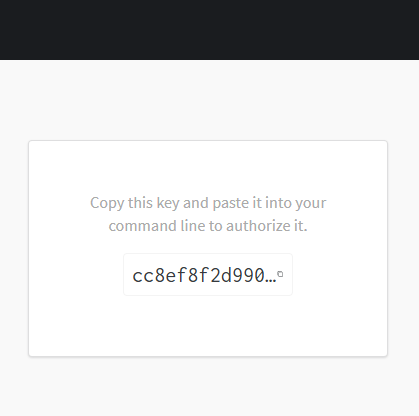


In [ ]:
!pip install wandb -qU

import wandb
from wandb import Api
from IPython.display import Markdown

## need to login
# wandb.login(anonymous="must")
wandb.login()

# dummy run to capture entity and project names
run = wandb.init(project="Jaca2425-sesion6", name="check-entity", reinit=True)
entity = run.entity
project = run.project
run.finish()

# Project and user information
display(Markdown(f"Captured **entity**: `{entity}` and **project**: `{project}`"))

#entity = "anonymous"
#project = "Jaca2425-sesion6"

wandb: Currently logged in as: purdeitx (unizar-purdeitx) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


✅ Captured **entity**: `unizar-purdeitx` and **project**: `Jaca2425-sesion6`

### Define sweep with the parameters to evaluate


### 2.2 Define Sweep Configuration

A **sweep** in wandb is a way to automatically explore combinations of hyperparameters and evaluate their effect on model performance. You define a configuration dictionary that specifies:

- The search method (e.g., grid, random, Bayesian).
- The metric to optimize (e.g., `val_accuracy`).
- The hyperparameters to vary and their possible values.


**Types of hyperparameter definitions:**

- `'values'`: A fixed list of discrete values (e.g., `[32, 64, 128]`).
- `'uniform'`: A continuous uniform distribution over a range (e.g., `min=0.0001`, `max=0.01`).
- `'int_uniform'`: Like `'uniform'`, but returns only integer values.
- `'q_uniform'`: Quantized uniform distribution (e.g., steps of 0.01).
- `'log_uniform'`: Uniform in log-space (useful for learning rates).
- `'categorical'`: Alternative to `values` when elements are strings or labels.

Below is an example of a sweep configuration that explores three hyperparameters: `learning_rate`, `hidden_size`, and `batch_size`.

```python
sweep_config = {
    'method': 'random',  # Options: 'grid', 'random', 'bayes'
    
    'metric': {
        'name': 'val_accuracy',  # Metric to optimize
        'goal': 'maximize'       # Can be 'maximize' or 'minimize'
    },
    'epoch': {value: 5}
    'parameters': {
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.01
        },
        'hidden_size': {
            'values': [64, 128, 256]
        },
        'batch_size': {
            'values': [32, 64, 128]
        }
    }
}
```

You can initialize the sweep on the wandb server with:

```python
sweep_id = wandb.sweep(sweep_config, project="my-sweep-project")
```

Then, you launch agents to run experiments with:

```python
wandb.agent(sweep_id, function=train_model, count=20)
```

Where `train_model` is the training function that uses `wandb.config` to access the current set of hyperparameters.

> Note: This setup allows you to systematically evaluate how each hyperparameter (and their interactions) affect model performance, while logging all results to the wandb dashboard.


In [ ]:
sweep_config = {
    # 'method': 'grid',
    # 'method': 'bayes',
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'value': 5},
        'hidden_size': {'values': [35, 64, 128, 256]},
        # lr en log
        'learning_rate': {
            'distribution': 'uniform',
            'min': 1e-3,
            'max': 1e-2,
            },
        'batch_size': {
            'distribution': 'int_uniform',
            'min': 64,
            'max': 128,
            },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project)

Create sweep with ID: p7acnkdm
Sweep URL: https://wandb.ai/unizar-purdeitx/Jaca2425-sesion6/sweeps/p7acnkdm


### Define training loop and WandB logs

One of the most important aspects of using wandb effectively is understanding that **wandb only logs the information that you explicitly pass to it**. If a metric or value is not sent using `wandb.log()`, it won't appear in your dashboard or be available for analysis.

Therefore, it is essential to carefully decide **what to log** during training and validation. The following is a list of commonly used metrics and metadata you may want to track:

#### Recommended items to log with `wandb.log()`

- **Training and Validation loss** (`train_loss`, `val_loss`)
- **Training and Validation accuracy** (`train_accuracy`,`val_accuracy`)
- **Gradient norms** (if monitoring training stability)
- **Custom metrics** (e.g., F1 score, precision, recall, entropy)
- **Any metric used for early stopping or model selection**

Additionally, it is good practice to log the following **configuration and metadata** using `wandb.init()` and `wandb.config`:

- Model architecture details (number of layers, hidden units, activation)
- Optimizer and its parameters (e.g., Adam, SGD)
- Dataset name or version
- Seed or random initialization values


#### ogging media and artifacts

Besides numerical values, wandb allows you to log various types of **media content** to make your experiments more interpretable:

- **Images** and **Plots** (e.g., input samples, reconstructions, segmentation outputs)
- **GIFs or videos** (e.g., visualizations of dynamics or training progress)
- **Audio clips** (for speech or music applications)
- **Custom files or models** using `wandb.Artifact`

These can be passed using `wandb.log({"example": wandb.Image(img)})` or other media-specific APIs.

> Note: Log only what is **useful** for diagnosing or comparing models, and avoid logging everything by default to prevent clutter or unnecessary storage use.


Once we are confident that the sweep configuration, logging strategy, and training loop are correctly set up, we are ready to launch our first sweep with a specified number of runs: `runs_num`

```python
wandb.agent(sweep_id, function=train_model, count=runs_num)
```


In [ ]:
# create a list to store results
results = []
runs_num = 5

def train():
    with wandb.init(tags=["train"]) as run:
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # DataLoader with batch_size variable
        train_loader = DataLoader(mnist_train, batch_size=config.batch_size, shuffle=True)

        # Define the model
        model = MLP(hidden_size=config.hidden_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Training
        for epoch in range(config.epochs):
            train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_accuracy": train_acc,
                "val_accuracy": val_acc
            })

        # Store results
        results.append({
            "epochs": config.epochs,
            "learning_rate": config.learning_rate,
            "hidden_size": config.hidden_size,
            "batch_size": config.batch_size,
            "val_accuracy": val_acc
        })

        # save final accuracy of the model
        wandb.run.summary["final_val_accuracy"] = val_acc
        wandb.run.summary["train_loss"] = train_loss

wandb.agent(sweep_id, train, count=runs_num)

wandb: Agent Starting Run: dfitjjy2 with config:
wandb: 	batch_size: 67
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0013711343632078553


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▆█
val_loss,█▄▂▂▁
epoch,5
final_val_accuracy,0.9789
train_accuracy,0.98603
train_loss,0.04131
val_accuracy,0.9789
val_loss,0.07327


wandb: Agent Starting Run: wj32l0e2 with config:
wandb: 	batch_size: 84
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.0028955590803699353


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆█▇
val_loss,█▃▃▁▂
epoch,5
final_val_accuracy,0.9597
train_accuracy,0.96788
train_loss,0.10704
val_accuracy,0.9597
val_loss,0.13652


wandb: Agent Starting Run: 2u1x2lvm with config:
wandb: 	batch_size: 69
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008234842193518074


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆█▆█
val_loss,█▂▁▅▂
epoch,5
final_val_accuracy,0.9632
train_accuracy,0.96452
train_loss,0.13484
val_accuracy,0.9632
val_loss,0.13963


wandb: Agent Starting Run: za0yah1w with config:
wandb: 	batch_size: 88
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.005464817295036885


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▄█
val_loss,█▅▁▃▂
epoch,5
final_val_accuracy,0.9559
train_accuracy,0.9589
train_loss,0.13571
val_accuracy,0.9559
val_loss,0.15874


wandb: Agent Starting Run: 4kant8wp with config:
wandb: 	batch_size: 85
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008034673896796844


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄█▅▇
val_loss,▇▆▁█▅
epoch,5
final_val_accuracy,0.9602
train_accuracy,0.96593
train_loss,0.11945
val_accuracy,0.9602
val_loss,0.15274


wandb: Agent Starting Run: xkhid12e with config:
wandb: 	batch_size: 108
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007154309743622277


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▂▁▇▆█
val_loss,▄█▂▂▁
epoch,5
final_val_accuracy,0.9653
train_accuracy,0.97073
train_loss,0.10487
val_accuracy,0.9653
val_loss,0.12435


wandb: Agent Starting Run: 592irrp2 with config:
wandb: 	batch_size: 106
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.003186771196682209


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▁█▆▇
val_loss,▄█▁▂▃
epoch,5
final_val_accuracy,0.972
train_accuracy,0.982
train_loss,0.05691
val_accuracy,0.972
val_loss,0.10282


wandb: Agent Starting Run: mv18rfgg with config:
wandb: 	batch_size: 82
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.0025660281788572404


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇█▇
val_loss,█▂▁▂▁
epoch,5
final_val_accuracy,0.9598
train_accuracy,0.97083
train_loss,0.09267
val_accuracy,0.9598
val_loss,0.1324


wandb: Agent Starting Run: k026kllk with config:
wandb: 	batch_size: 110
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.004070139709955164


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▂▇▆█
val_loss,██▂▂▁
epoch,5
final_val_accuracy,0.97
train_accuracy,0.9752
train_loss,0.07893
val_accuracy,0.97
val_loss,0.10161


wandb: Agent Starting Run: tqbyensf with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.006142844980578237


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▂▁▇▇█
val_loss,▇█▃▂▁
epoch,5
final_val_accuracy,0.963
train_accuracy,0.96322
train_loss,0.12479
val_accuracy,0.963
val_loss,0.1346


wandb: Agent Starting Run: qluzyqus with config:
wandb: 	batch_size: 117
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00785148315109269


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▅▇██
val_loss,█▆▁▃▃
epoch,5
final_val_accuracy,0.9582
train_accuracy,0.96745
train_loss,0.10927
val_accuracy,0.9582
val_loss,0.14492


wandb: Agent Starting Run: hadvta72 with config:
wandb: 	batch_size: 104
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002033928192196029


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▅▄█
val_loss,█▁▄▇▂
epoch,5
final_val_accuracy,0.9785
train_accuracy,0.98582
train_loss,0.04391
val_accuracy,0.9785
val_loss,0.08363


wandb: Agent Starting Run: c52ych76 with config:
wandb: 	batch_size: 95
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006605776233044233


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅█▇▆
val_loss,█▆▁▃▆
epoch,5
final_val_accuracy,0.9626
train_accuracy,0.9703
train_loss,0.10304
val_accuracy,0.9626
val_loss,0.1455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5g1tbhv with config:
wandb: 	batch_size: 75
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.009179207776385008


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▂▆█
val_loss,█▁█▂▃
epoch,5
final_val_accuracy,0.9501
train_accuracy,0.95425
train_loss,0.15715
val_accuracy,0.9501
val_loss,0.19029


wandb: Agent Starting Run: wb6li57a with config:
wandb: 	batch_size: 72
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.005593127008165924


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▃▃▁
epoch,5
final_val_accuracy,0.9658
train_accuracy,0.97365
train_loss,0.09323
val_accuracy,0.9658
val_loss,0.11793


wandb: Agent Starting Run: oxggjngc with config:
wandb: 	batch_size: 97
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.0021792607509081947


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆█▇
val_loss,█▅▃▁▂
epoch,5
final_val_accuracy,0.9587
train_accuracy,0.97055
train_loss,0.09566
val_accuracy,0.9587
val_loss,0.1343


wandb: Agent Starting Run: 0l05osov with config:
wandb: 	batch_size: 86
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004341136003771854


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▂▅█▆
val_loss,█▆▅▁▅
epoch,5
final_val_accuracy,0.9683
train_accuracy,0.9775
train_loss,0.07445
val_accuracy,0.9683
val_loss,0.11358


wandb: Agent Starting Run: nh156723 with config:
wandb: 	batch_size: 99
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.006167149850189164


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▂▁▂▆█
val_loss,▇██▃▁
epoch,5
final_val_accuracy,0.9612
train_accuracy,0.96462
train_loss,0.11901
val_accuracy,0.9612
val_loss,0.13246


wandb: Agent Starting Run: q4zx44v3 with config:
wandb: 	batch_size: 72
wandb: 	epochs: 5
wandb: 	hidden_size: 35
wandb: 	learning_rate: 0.009785269633683372


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▄█▆
val_loss,█▅▇▁▄
epoch,5
final_val_accuracy,0.9536
train_accuracy,0.95442
train_loss,0.16049
val_accuracy,0.9536
val_loss,0.1823


wandb: Agent Starting Run: yg8qhgl5 with config:
wandb: 	batch_size: 68
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001848746406373058


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▁▂▄
epoch,5
final_val_accuracy,0.9739
train_accuracy,0.98552
train_loss,0.04557
val_accuracy,0.9739
val_loss,0.09774


### Data collection

Once the sweep has completed, all training data and results are already stored in wandb.  

However, before exploring the wandb web application, we will first examine what insights we can extract and visualize locally within this notebook. To do that, we have prepared the next code to access to the stored date.




In [ ]:
# login
# API initialization
api = Api()

# Alternative to work with anonymous
all_runs = api.runs(f"{entity}/{project}", {"state": "finished"})
# Exclude 'check-entity'
runs = [run for run in all_runs if run.name != "check-entity"]

# load data to plot results
lrs = []
accs = []
hidd  = []
btch = []

# or load data stored in a local list
#lrs = [res["learning_rate"] for res in results]
#accs = [res["val_accuracy"] for res in results]

for run in runs:
    if run.state == "finished":
        config = run.config
        summary = run.summary
        if "val_accuracy" in summary:
            lrs.append(config.get("learning_rate"))
            accs.append(summary.get("val_accuracy"))
            hidd.append(config.get("hidden_size"))
            btch.append(config.get("batch_size"))


### 1. Training vs. Validation Loss Curve

This plot helps identify overfitting or underfitting by comparing the training loss and validation accuracy over epochs.

Check the **"Line Plot" tab** in your wandb run to visualize how `train_loss` and `val_accuracy` evolve across epochs.


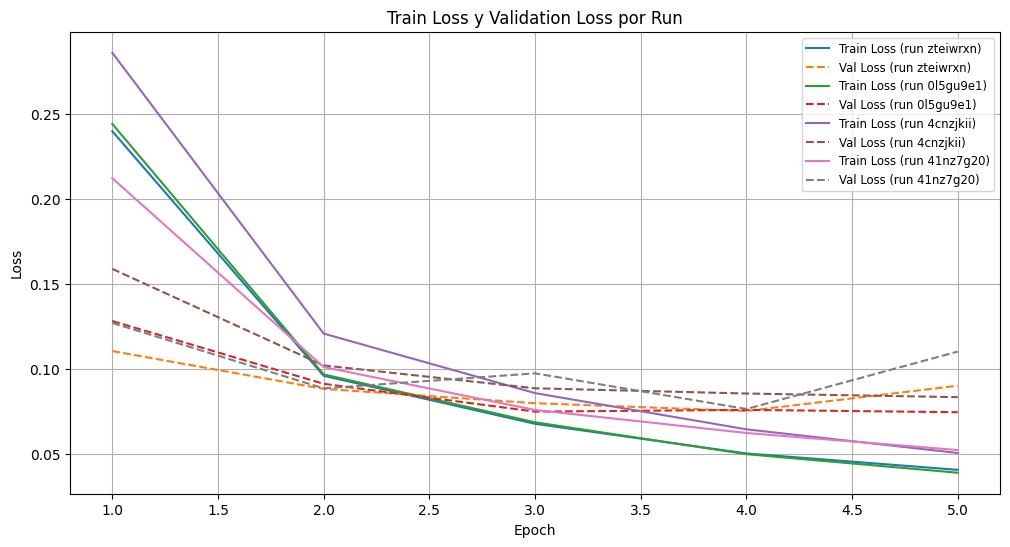

In [ ]:
plt.figure(figsize=(12, 6))

for run in runs:
    if run.state == "finished":
        history = run.history()  # DataFrame with all the data for each epoch
        epochs = history["epoch"].values
        train_loss = history["train_loss"].values
        val_loss = history["val_loss"].values

        # train_loss
        plt.plot(epochs, train_loss, label=f"Train Loss (run {run.id})", linestyle='-')
        # val_loss
        plt.plot(epochs, val_loss, label=f"Val Loss (run {run.id})", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss y Validation Loss por Run")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)

### 2. Accuracy over Epochs (Multiple Runs)

Compare the accuracy curves across different runs to analyze the consistency of each hyperparameter configuration.

In wandb, go to the "Compare Runs" panel and overlay the `val_accuracy` metric for different runs.


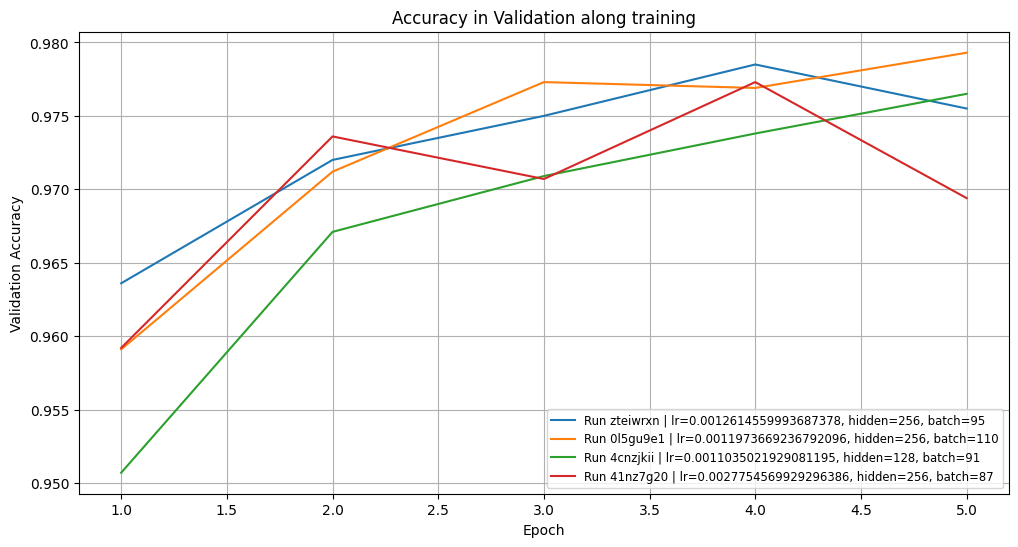

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for run in runs:
    if run.state == "finished":
        history = run.history()  # DataFrame with metrics for each epoch
        epochs = history["epoch"].values
        val_acc = history["val_accuracy"].values
        config = run.config
        label = (f"Run {run.id} | lr={config.get('learning_rate')}, "
                 f"hidden={config.get('hidden_size')}, batch={config.get('batch_size')}")

        plt.plot(epochs, val_acc, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy in Validation along training")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()


### 3. Scatter Plots: Validation Accuracy vs. Hyperparameters

These scatter plots reveal how sensitive the model's performance is to each individual hyperparameter.

We analyze three key parameters:

- Learning Rate
- Hidden Layer Size
- Batch Size

Use these to identify thresholds or saturation regions in accuracy.


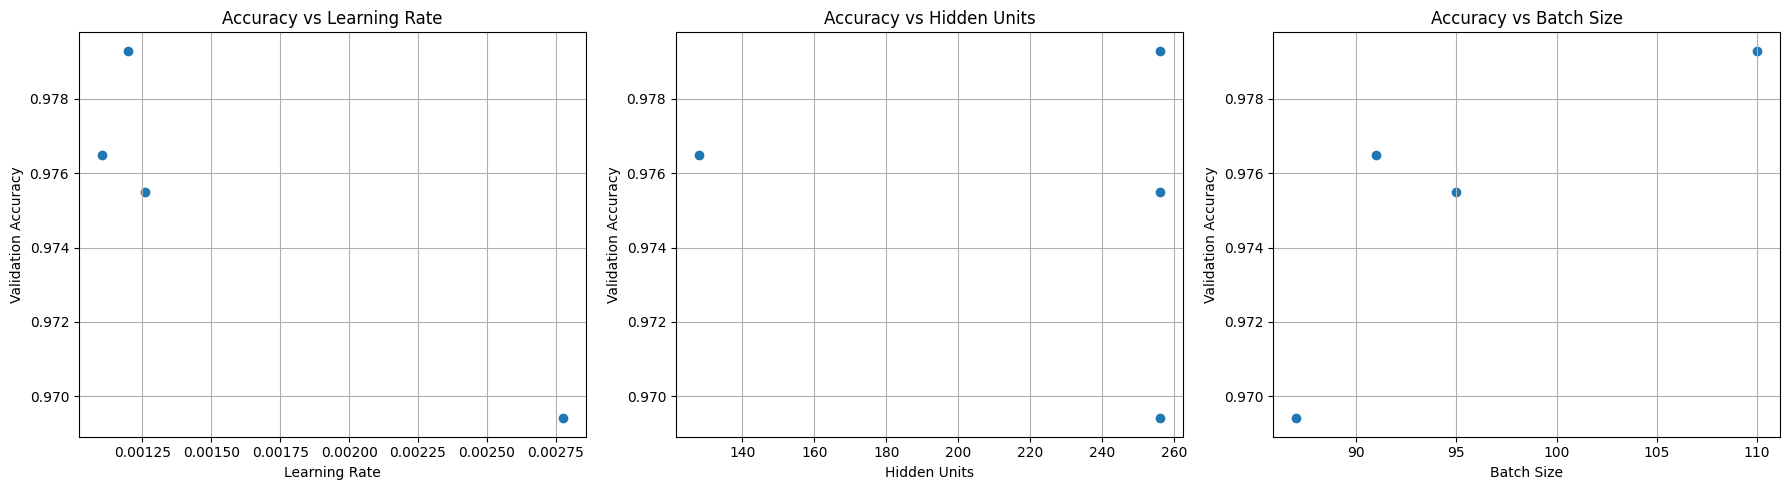

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython import get_ipython
from IPython.display import display

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy vs Learning Rate
axes[0].scatter(lrs, accs)
#axes[0].set_xscale('log')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Accuracy vs Learning Rate")
axes[0].grid(True)

# Accuracy vs Hidden Units
axes[1].scatter(hidd, accs)
#axes[1].set_xscale('log')
axes[1].set_xlabel("Hidden Units")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Accuracy vs Hidden Units")
axes[1].grid(True)

# Accuracy vs Batch Size
axes[2].scatter(btch, accs)
#axes[2].set_xscale('log')
axes[2].set_xlabel("Batch Size")
axes[2].set_ylabel("Validation Accuracy")
axes[2].set_title("Accuracy vs Batch Size")
axes[2].grid(True)

plt.tight_layout()
plt.show()


### 4. Sweep Summary Table

This table summarizes all completed runs in the sweep, allowing easy comparison of final performance.

Top configurations sorted by validation accuracy:


In [ ]:
# collect all data and summarize:
data = []
for run in runs:
    if run.state == "finished":
        data.append({
            "Run ID": run.id,
            "lr": run.config.get("learning_rate"),
            "batch_size": run.config.get("batch_size"),
            "hidden_size": run.config.get("hidden_size"),
            "val_acc": run.summary.get("val_accuracy"),
            "train_loss": run.summary.get("train_loss"),
        })

df = pd.DataFrame(data)
df.sort_values(by="val_acc", ascending=False, inplace=True)
df.head(10)

,Run ID,lr,batch_size,hidden_size,val_acc,train_loss
1,0l5gu9e1,0.001197,110,256,0.9793,0.039231
2,4cnzjkii,0.001104,91,128,0.9765,0.050822
0,zteiwrxn,0.001261,95,256,0.9755,0.040918
3,41nz7g20,0.002775,87,256,0.9694,0.052558


### 5. Parallel Coordinates Plot

Parallel coordinates plots provide a global view of how combinations of hyperparameters affect a chosen metric (e.g., validation accuracy). Each line represents a run, and the plot shows the interaction between parameters.

In your wandb dashboard, open the sweep view and click on "Parallel Coordinates" to explore this visualization.

**GO TO WandB App:**

1. go to WandB: [https://wandb.ai/YOUR-ENTITY/YOUR-PROJECT](https://wandb.ai/YOUR-ENTITY/YOUR-PROJECT)

2. Open the **"Sweeps"** tab and select your sweep.

3. On the left sidebar, select **"Parallel Coordinates"**.

4. Choose the metric to optimize (e.g., `val_accuracy`) and select the hyperparameters to visualize.

This visualization is useful for:

- Discovering high-performing combinations of hyperparameters
- Understanding correlations between parameters
- Identifying trade-offs between different configurations





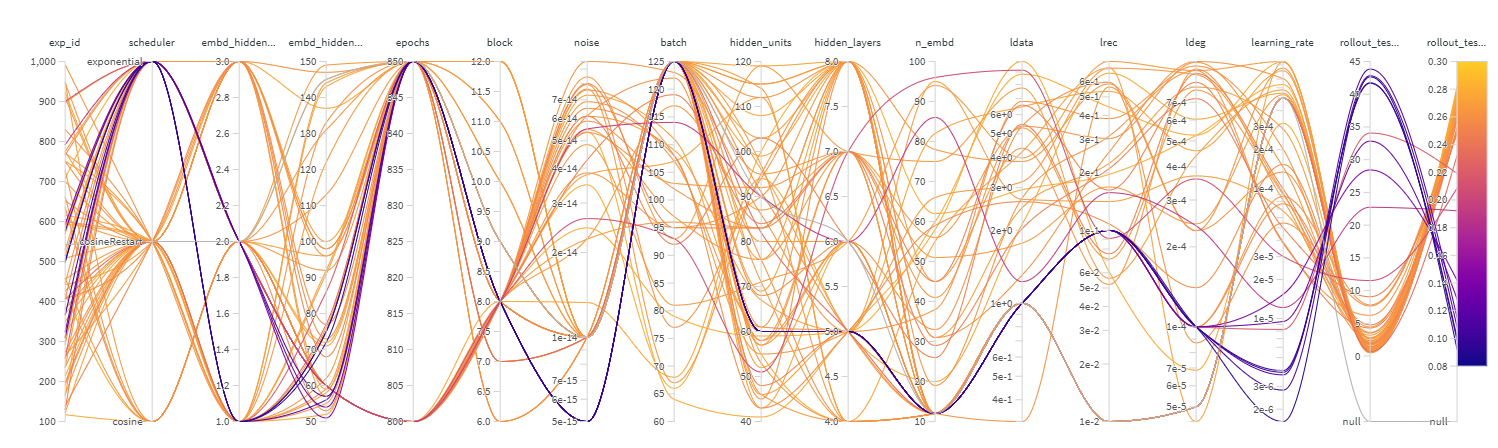

### 6. Hyperparameter Importance

wandb can automatically estimate which hyperparameters have the greatest effect on a selected metric, such as `val_accuracy`. This is based on a model-based importance analysis across all completed runs in the sweep.

Navigate to the "Hyperparameter Importance" tab in the sweep dashboard to explore this feature.

This tool is helpful for:

- Prioritizing hyperparameters that significantly impact model performance
- Reducing the dimensionality of the search space by fixing low-impact parameters
- Gaining intuition about the sensitivity of your model to specific configuration choices

> Note: This analysis becomes more reliable with a larger and more diverse set of runs.


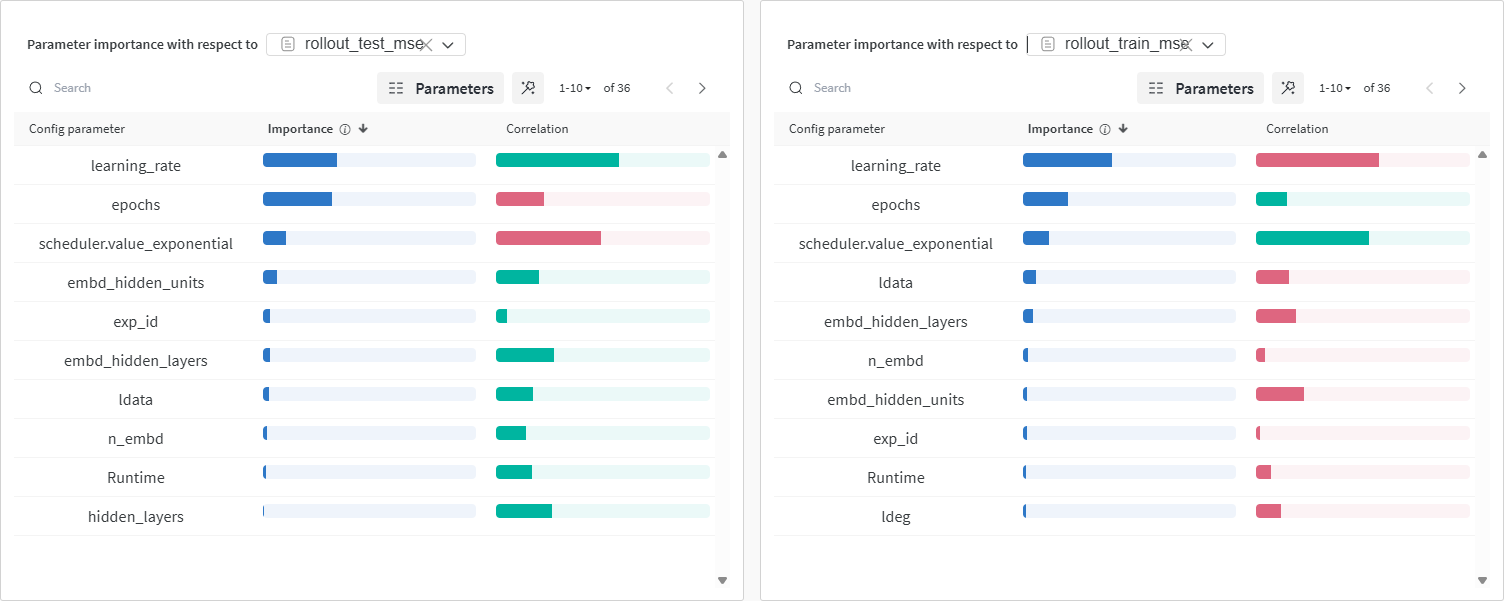

### 7. Histograms of Validation Accuracy

Use histograms to analyze the variability and consistency of model performance across different runs.

Histograms help you understand the distribution and variability of key metrics across all runs in a sweep. For example, visualizing the distribution of `val_accuracy` can reveal how consistent your model is across different hyperparameter settings.

Open the "Histogram" tab in the wandb sweep view and select `val_accuracy`.

This visualization allows you to:

- Assess performance variability across runs
- Identify robust configurations
- Detect outliers or multimodal distributions in performance

> Note: Make sure that the metrics are logged correctly using `wandb.log()` or stored in the run summary with `wandb.run.summary[...]`.


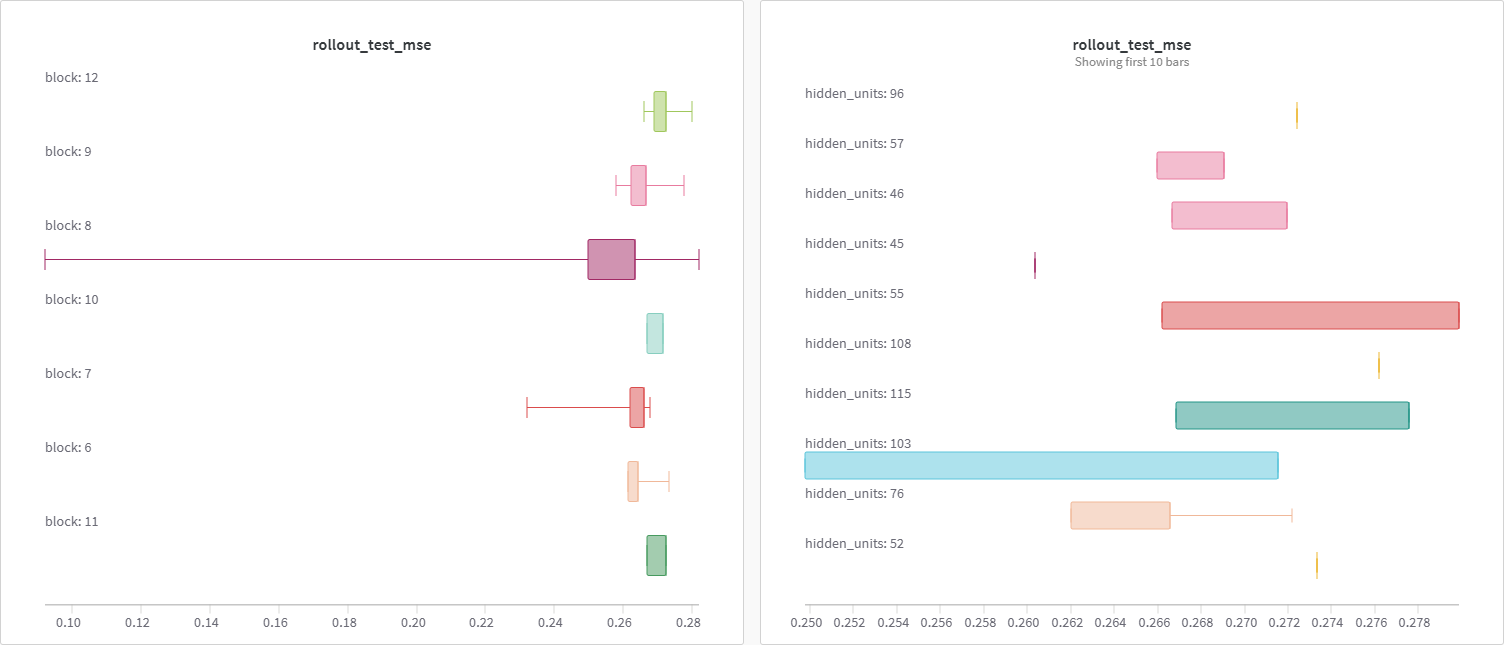

### 8. Line Plot (Overlay of Multiple Runs)

This visualization overlays the training curves (e.g., `val_accuracy` or `train_loss`) from multiple runs in the sweep. It is essential for comparing learning dynamics across different hyperparameter configurations.

Compare the training curves across several runs to detect divergence, instability, or convergence patterns.

Use wandb's "Line Plot" tab and select multiple runs to overlay them.

This visualization is useful for:

- Comparing convergence speed and stability across runs
- Detecting training instabilities or overfitting
- Identifying runs that outperform others early or late in training

> Note: Use filters (e.g., by batch size or learning rate) to narrow down comparisons to similar configurations.





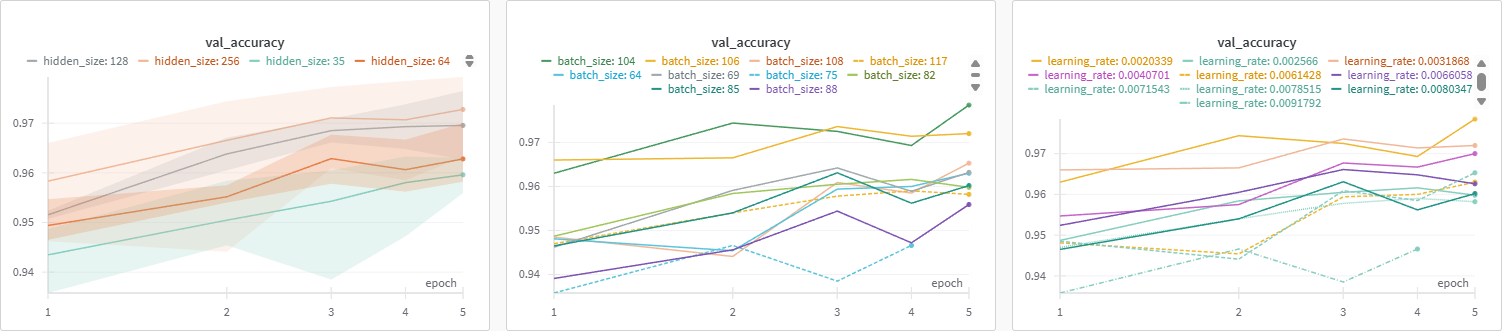

## Non trivial example: Lest try yourself

## Discussion and Conclusions:

In this session, we have explored the integration of **Weights & Biases (wandb)** for monitoring and optimizing machine learning models through hyperparameter tuning. By using a sweep-based strategy, we were able to evaluate the impact of several key hyperparameters on the final performance of the Net.

Through various visualizations (loss curves, accuracy plots, scatter plots, parallel coordinates, and importance charts), students gained insight into:

- How different hyperparameters affect training dynamics and generalization.
- Which regions of the parameter space lead to optimal or suboptimal results.
- How wandb facilitates comparison across runs, automatic logging, and the organization of experiments.

The results demonstrate the utility of `wandb` not only as a logging tool but as a powerful assistant for **experimental design** and **model selection**. The sweep summary table, in particular, allows us to quickly identify the top-performing configurations, while the visual tools help to interpret why certain choices succeed or fail.

In the next sessions, we will move beyond general-purpose architectures and explore **domain-informed neural networks**, specifically those that incorporate **thermodynamic and geometric biases**. These biases can be embedded both:

- At the architectural level (e.g., by enforcing symmetries, conservation laws, or energy-based structures), and  
- At the loss function level (e.g., by penalizing violations of thermodynamic consistency or entropy production).

We will analyze how these structured inductive biases can improve learning efficiency, physical plausibility, and generalization when modeling dynamical systems or physical processes. This approach bridges deep learning with principles from **non-equilibrium thermodynamics**, and paves the way for hybrid models that combine data-driven learning with physical co


# **References**
[1]. Ian Goodfellow and Yoshua Bengio and Aaron Courville. *Deep Learning*. Deep Learning (2016). [http://www.deeplearningbook.org](http://www.deeplearningbook.org)

[2]. Weights & Biases Documentation. *Official guide and API reference for experiment tracking, sweeps, and visualization tools.*  
   [https://docs.wandb.ai](https://docs.wandb.ai)

[3].


# **License**

Creative Commons Attribution-NonCommercial 4.0 International License

You are free to:
- Share — copy and redistribute the material in any medium or format
- Adapt — remix, transform, and build upon the material

Under the following terms:
- Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
- NonCommercial — You may not use the material for commercial purposes.

No additional restrictions — You may not apply legal terms or technological measures that legally restrict others from doing anything the license permits.

Full license details: https://creativecommons.org/licenses/by-nc/4.0/